## Import Tensor Flow ##

In [38]:
import pathlib
import tensorflow as tf
'''
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')
'''

'\ndataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"\narchive = tf.keras.utils.get_file(origin=dataset_url, extract=True)\ndata_dir = pathlib.Path(archive).with_suffix(\'\')\n'

## Split Folders ##

In [39]:
import splitfolders

splitfolders.ratio('./Images2', output="./dogs_split_data", ratio=(0.7, 0.15, 0.15))

Copying files: 0 files [00:00, ? files/s]

Copying files: 5770 files [00:33, 174.56 files/s]


## Model process ##

### Step 1: Import libraries and load the dataset ###


In [54]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from PIL import Image

# This Code Needs to be Updated when Input Size is Changed 

# Set the path to the dataset folder
data_path = "./dogs_split_data"

# Create data generators for training and test
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)  

# Test the model on a few samples
test_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "test"),
    target_size=(256, 256),
    batch_size=1,
    class_mode='categorical', 
    shuffle=False
)

Found 4024 images belonging to 29 classes.
Found 853 images belonging to 29 classes.
Found 893 images belonging to 29 classes.


### Step 2: Load the datasets and display sample images ###

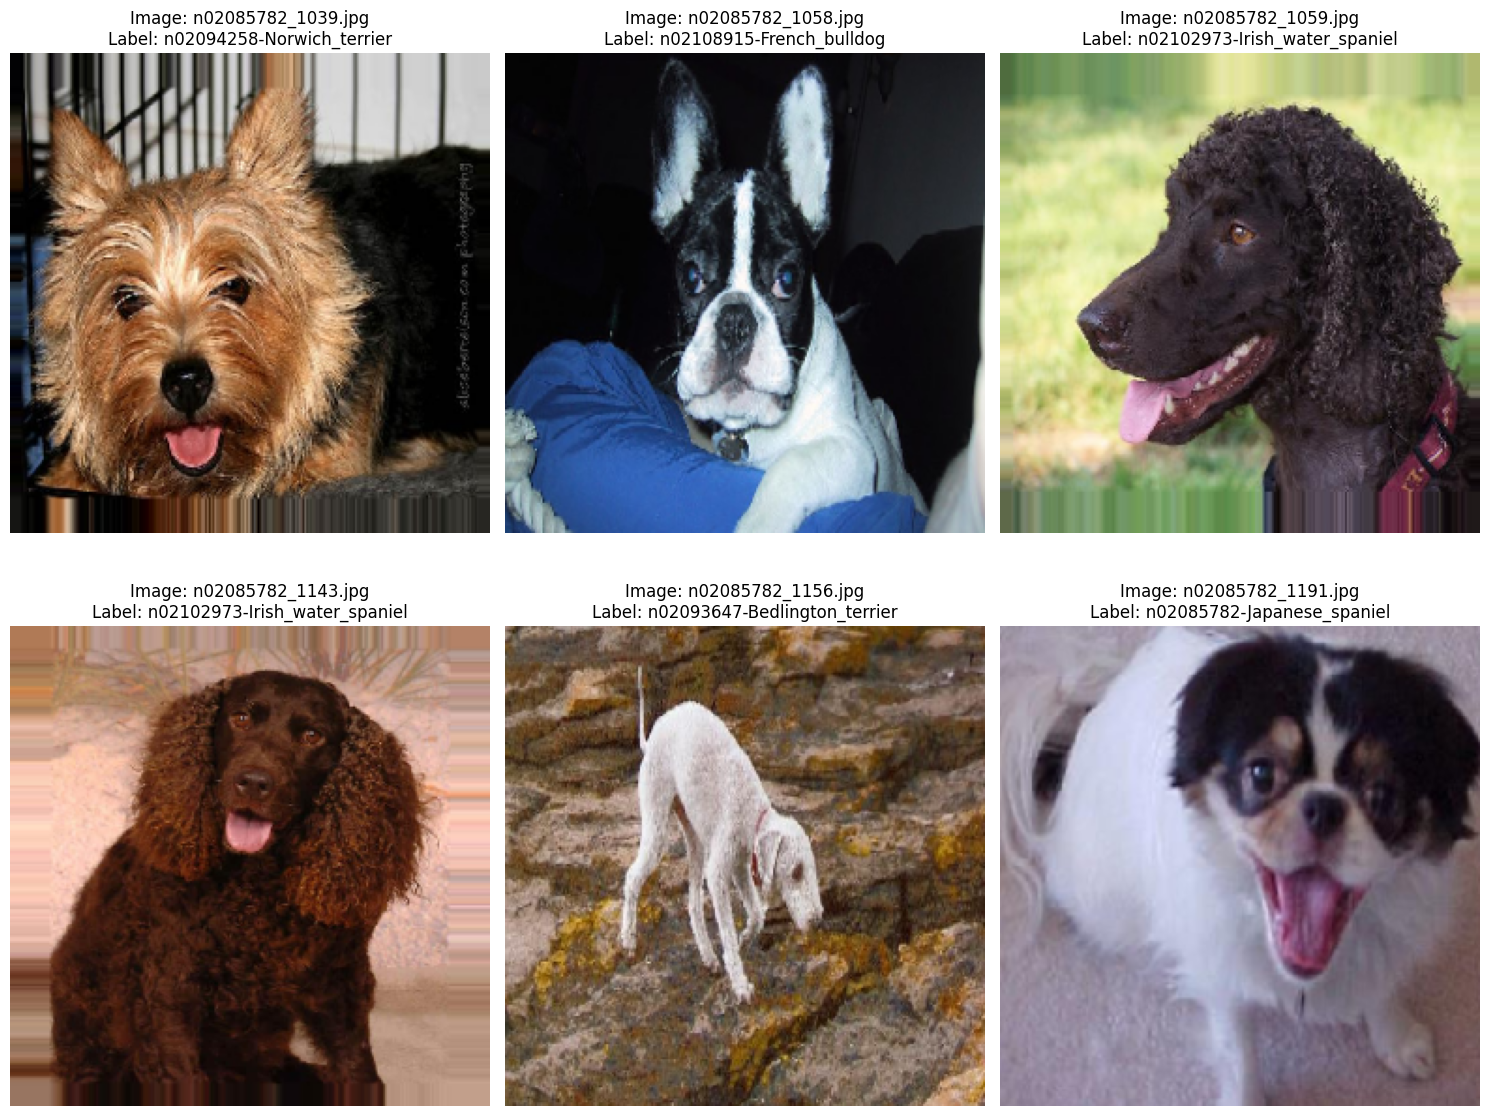

In [48]:
# Get the class indices mapping (class labels to class names)
class_indices = train_generator.class_indices

# Display 6 sample images from the training set along with their filenames and training labels
plt.figure(figsize=(15, 12))
for i in range(6):
    img, label = train_generator.next()
    img_filename = train_generator.filenames[train_generator.batch_index - 1]  # Get the filename of the current image
    img_class = list(class_indices.keys())[list(class_indices.values()).index(label[0].argmax())]  # Get the class name
    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f"Image: {os.path.basename(img_filename)}\nLabel: {img_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Check if GPU Acceleration is Available ##

In [49]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

Num GPUs Available:  0


### Step 3: Build the CNN model ###

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

model = Sequential()

# Convolutional layers with added L2 regularization and increased depth
model.add(Conv2D(32, (3, 3), activation="relu", kernel_regularizer=l2(0.001), input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Using Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())

# Dense layers with added L2 regularization and adjusted units
model.add(Dense(units=512, activation="relu", kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(units=256, activation="relu", kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

# Correcting the number of classes to 30
model.add(Dense(units=20, activation="softmax"))

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks_list = [reduce_lr, early_stop, checkpoint]



In [67]:
history = model.fit(train_generator, validation_data=val_generator, epochs=50, batch_size=32, callbacks=callbacks_list)


Epoch 1/50
82/82 [==============================] - 154s 2s/step - loss: 4.6589 - accuracy: 0.0854 - val_loss: 4.7104 - val_accuracy: 0.0713 - lr: 0.0010
Epoch 2/50
82/82 [==============================] - 156s 2s/step - loss: 4.2944 - accuracy: 0.1127 - val_loss: 4.7757 - val_accuracy: 0.0878 - lr: 0.0010
Epoch 3/50
82/82 [==============================] - 155s 2s/step - loss: 4.0688 - accuracy: 0.1308 - val_loss: 4.4232 - val_accuracy: 0.0951 - lr: 0.0010
Epoch 4/50
82/82 [==============================] - 154s 2s/step - loss: 3.8788 - accuracy: 0.1504 - val_loss: 4.8293 - val_accuracy: 0.0658 - lr: 0.0010
Epoch 5/50
82/82 [==============================] - 155s 2s/step - loss: 3.7068 - accuracy: 0.1716 - val_loss: 4.5261 - val_accuracy: 0.0859 - lr: 0.0010
Epoch 6/50
82/82 [==============================] - 156s 2s/step - loss: 3.5829 - accuracy: 0.1751 - val_loss: 3.7895 - val_accuracy: 0.1152 - lr: 0.0010
Epoch 7/50
82/82 [==============================] - 154s 2s/step - loss: 3.4

In [75]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_28 (Ba  (None, 254, 254, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_29 (Ba  (None, 125, 125, 32)      128       
 tchNormalization)                                               
                                                      

## Training Progress ##

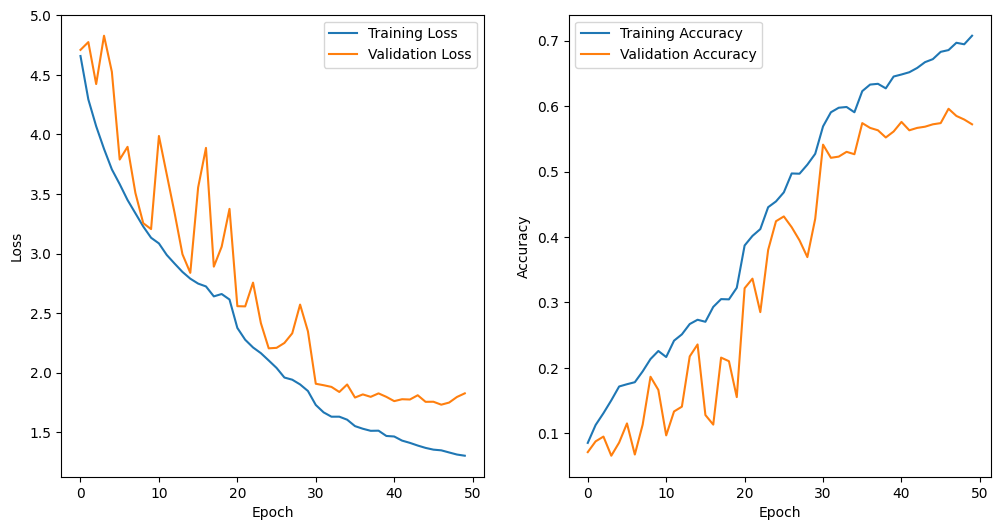

In [71]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## Test Model ##

579/579 [==============================] - 12s 20ms/step


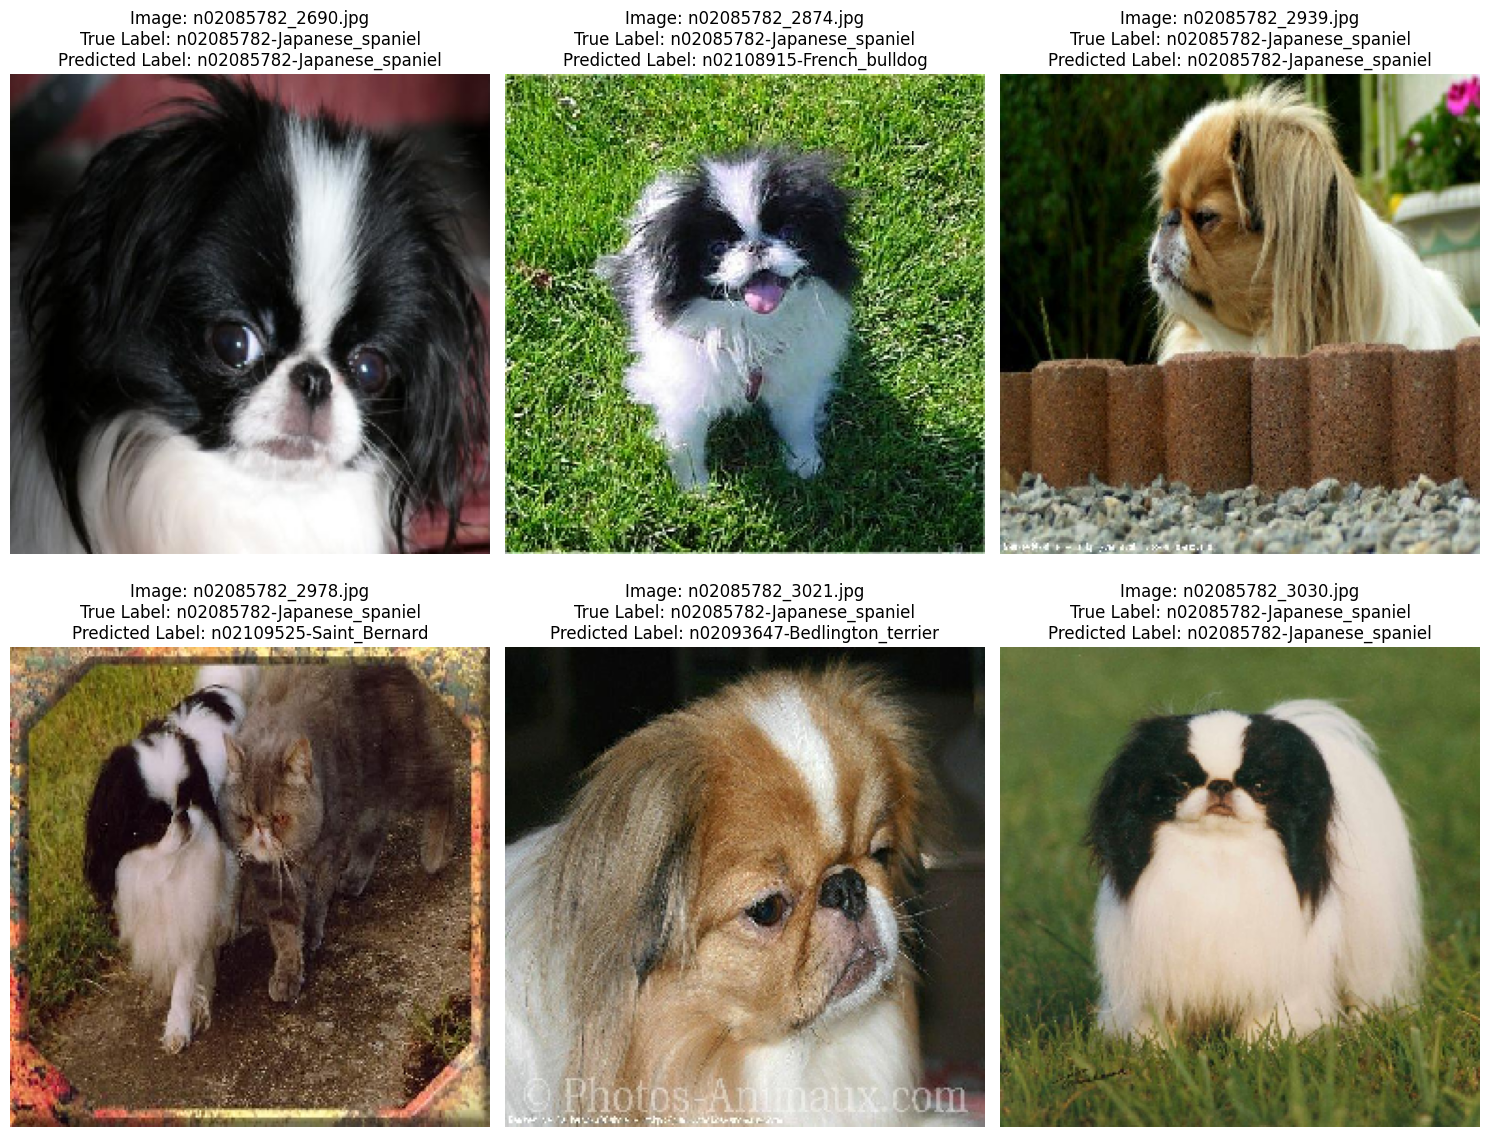

In [72]:
# Predict on the test set
predictions = model.predict(test_generator)

# Display some sample images from the test set along with their true and predicted labels
plt.figure(figsize=(15, 12))
for i in range(6):
    img, true_label = test_generator.next()
    img_filename = test_generator.filenames[test_generator.batch_index - 1]  # Get the filename of the current image
    true_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(true_label.argmax())]  # Get the true class name
    predicted_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(predictions[i].argmax())]  # Get the predicted class name

    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f"Image: {os.path.basename(img_filename)}\nTrue Label: {true_class}\nPredicted Label: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Evaluate on Test Set ##

In [73]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

579/579 [==============================] - 11s 20ms/step - loss: 1.9813 - accuracy: 0.5492
Test Loss: 1.9813
Test Accuracy: 0.5492


## Testing Using Online Image ##

1/1 [==============================] - 0s 56ms/step


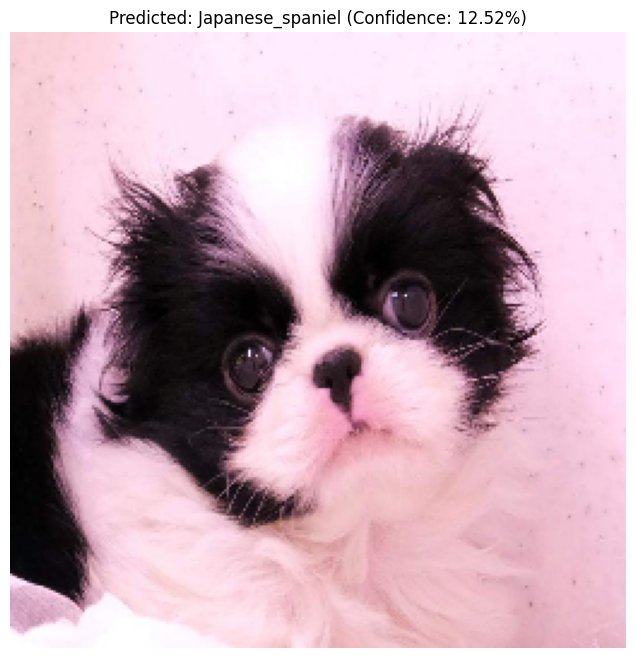

In [88]:
from keras.models import load_model
import tensorflow as tf

img_height=256
img_width=256

# Load the best model saved during training
model = load_model("./best_model.h5")

# Direct link to the image file
img_url = "https://upload.wikimedia.org/wikipedia/commons/3/38/Japanese_ChinJapanese_Spaniel.jpg"
# Download the image and get the local path
img_path = tf.keras.utils.get_file('jap.jpg', origin=img_url)

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

# Now, you can pass this 'image' to the model for prediction:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_names = ['Japanese_spaniel', 'Maltese_dog', 'Tzu', 'papillon', 'Afghan_hound', 'beagle', 'bloodhound', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Saluki', 'Scottish_deerhound', 'Bedlington_terrier', 'Norwich_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Dandie_Dinmont', 'Boston_bull', 'Lhasa', 'miniature_pinscher', 'Bernese_mountain_dog', 'EntleBucher', 'malamute', 'Siberian_husky', 'basenji', 'pug']

# Display the image with the predicted class and confidence
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title(
    "Predicted: {} (Confidence: {:.2f}%)".format(class_names[np.argmax(score)], 100 * np.max(score))
)
plt.show()

## Testing Using Image From Dataset ##

1/1 [==============================] - 0s 284ms/step


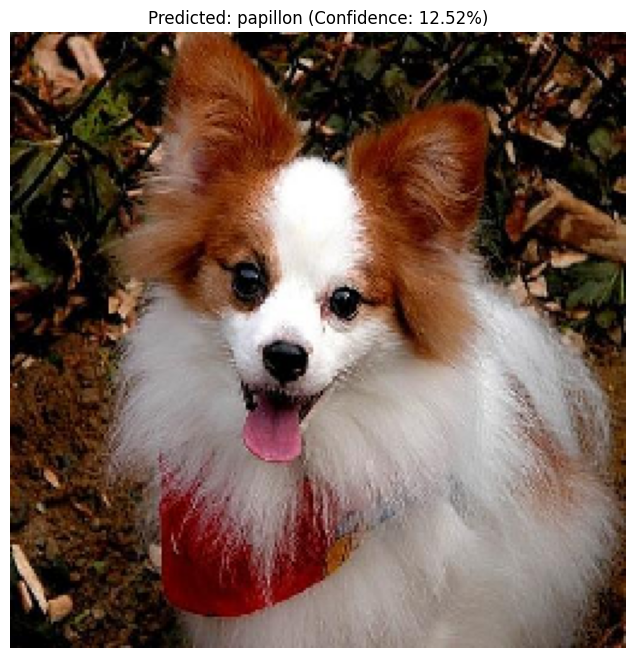

In [83]:
import numpy as np
import tensorflow as tf
from keras.models import load_model

img_height = 256
img_width = 256

# Load the best model saved during training
model = load_model("./best_model.h5")

# Load and preprocess the image
image_path = "./Images2/n02086910-papillon/n02086910_9527.jpg"
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_names = ['Japanese_spaniel', 'Maltese_dog', 'Tzu', 'papillon', 'Afghan_hound', 'beagle', 'bloodhound', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Saluki', 'Scottish_deerhound', 'Bedlington_terrier', 'Norwich_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Dandie_Dinmont', 'Boston_bull', 'Lhasa', 'miniature_pinscher', 'Bernese_mountain_dog', 'EntleBucher', 'malamute', 'Siberian_husky', 'basenji', 'pug']

# Display the image with the predicted class and confidence
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title(
    "Predicted: {} (Confidence: {:.2f}%)".format(class_names[np.argmax(score)], 100 * np.max(score))
)
plt.show()

## Get Classification Names ##
This is for updating the classification names in case that the dataset is ever updated

In [2]:
import os

# Specify the directory containing the folders
directory_path = ".\Images2"

# Check if the directory exists
if not os.path.exists(directory_path):
    print(f"The directory '{directory_path}' does not exist.")
else:
    # List all items (files and folders) in the directory
    items = os.listdir(directory_path)

    # Filter only the folders (subdirectories)
    subdirectories = [item for item in items if os.path.isdir(os.path.join(directory_path, item))]

    # Extract and print the folder names
    for folder in subdirectories:
        folder_name = folder.split("-")[-1]
        print(f"'{folder_name}',")


'Japanese_spaniel',
'Maltese_dog',
'Tzu',
'papillon',
'Afghan_hound',
'beagle',
'bloodhound',
'Irish_wolfhound',
'Italian_greyhound',
'whippet',
'Ibizan_hound',
'Saluki',
'Scottish_deerhound',
'Bedlington_terrier',
'Norwich_terrier',
'Lakeland_terrier',
'Sealyham_terrier',
'Airedale',
'cairn',
'Dandie_Dinmont',
'Boston_bull',
'Lhasa',
'miniature_pinscher',
'Bernese_mountain_dog',
'EntleBucher',
'malamute',
'Siberian_husky',
'basenji',
'pug',


# Conclusion #